In [1]:
import sys

sys.path.insert(1, "../")

In [2]:
from em_algo.models import WeibullModelExp, GaussianModel, ExponentialModel
from em_algo.types import *
from em_algo.distribution_mixture import DistributionMixture, DistributionInMixture
from examples.utils import SingleSolverResult

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import itertools

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [3]:
from examples.utils import *

results = open_results("big_mono_test")

In [4]:
from examples.prepare_result import prepare

df = prepare(results)
df["occur"] = df["occur"].replace([np.inf, -np.inf], np.nan)

  0%|          | 0/92160 [00:00<?, ?it/s]

In [5]:
df["error"].unique()

array([None], dtype=object)

In [6]:
df = df.drop(columns=["error"])

In [7]:
df["success"] = (df["steps"] < 16) & any(df["result_mixture"].values)

In [8]:
df["success"].value_counts()

success
True     61211
False    30949
Name: count, dtype: int64

In [9]:
df["failed"].value_counts()

failed
False    90914
True      1246
Name: count, dtype: int64

In [10]:
df.head()

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
0,0,ScipyCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.045785,WeibullExp,50,True,False,1.345529
1,0,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.039017,WeibullExp,50,True,False,1.345529
2,0,ScipySLSQP,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.037471,WeibullExp,50,True,False,1.345531
3,0,ScipyTNC,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.043206,WeibullExp,50,True,False,1.345528
4,1,ScipyCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.255229,WeibullExp,50,True,False,1.345529


In [11]:
df.select_dtypes(["number", "bool"])

,test_index,k,steps,time,size,success,failed,occur
0,0,1,2,0.045785,50,True,False,1.345529
1,0,1,2,0.039017,50,True,False,1.345529
2,0,1,2,0.037471,50,True,False,1.345531
3,0,1,2,0.043206,50,True,False,1.345528
4,1,1,2,0.255229,50,True,False,1.345529
...,...,...,...,...,...,...,...,...
92155,23038,3,7,1.421419,1000,True,False,0.444505
92156,23039,3,13,4.619542,1000,True,False,0.443455
92157,23039,3,13,5.624392,1000,True,False,0.443455
92158,23039,3,13,4.755351,1000,True,False,0.443456


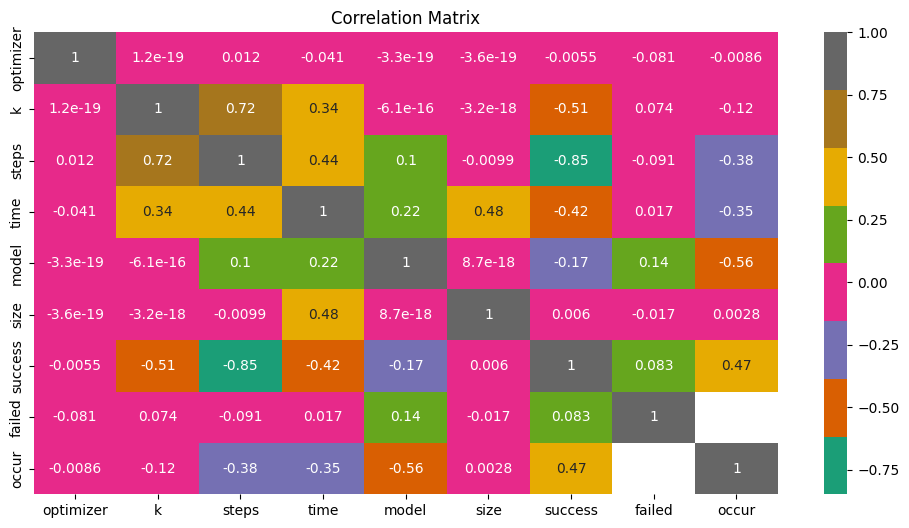

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = (
    df.drop(columns=["true_mixture", "result_mixture", "sample", "log"])
    .select_dtypes(include=["object"])
    .columns
)

corr_df = pd.DataFrame(df)

for col in categorical_cols:
    corr_df[col] = le.fit_transform(df[col])

corr_df = corr_df.select_dtypes(["number", "bool"])
corr_df = corr_df.drop(columns=["test_index"])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
corr_df = pd.DataFrame(scaler.fit_transform(corr_df), columns=corr_df.columns)

df_corr = corr_df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()

In [13]:
df[df["optimizer"] == "ScipyNewtonCG"]

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
1,0,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.039017,WeibullExp,50,True,False,1.345529
5,1,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.165643,WeibullExp,50,True,False,1.345529
9,2,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.087084,WeibullExp,50,True,False,1.345529
13,3,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.127498,WeibullExp,50,True,False,1.345529
17,4,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.081151,WeibullExp,50,True,False,1.345529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92141,23035,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,1.018595,Exponential,1000,True,False,0.442576
92145,23036,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,6.210426,Exponential,1000,False,False,0.444245
92149,23037,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],11,4.514465,Exponential,1000,True,False,0.443906
92153,23038,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],7,1.331243,Exponential,1000,True,False,0.444505


In [14]:
for opt in df["optimizer"].unique():
    print(opt)
    print(df[df["optimizer"] == opt]["failed"].value_counts())
    print("time")
    print(df[df["optimizer"] == opt]["time"].mean())
    print("steps")
    print(df[df["optimizer"] == opt]["steps"].mean())
    print("occur")
    print(df[df["optimizer"] == opt]["occur"].mean())
    print()

ScipyCG
failed
False    22373
True       667
Name: count, dtype: int64
time
5.717425486933222
steps
8.442838541666667
occur
-1.569184633972185

ScipyNewtonCG
failed
False    22748
True       292
Name: count, dtype: int64
time
4.500826544573996
steps
8.701779513888889
occur
-1.5887504950529545

ScipySLSQP
failed
False    22797
True       243
Name: count, dtype: int64
time
3.627200289584775
steps
8.643446180555555
occur
-1.5872305692900557

ScipyTNC
failed
False    22996
True        44
Name: count, dtype: int64
time
4.886238893902783
steps
8.686805555555555
occur
-1.627795400315431



In [15]:
print(df["occur"].min())
print(df["occur"].max())

-14.13727946131802
1.925573931953645


In [16]:
mdf = df[df["k"] > 1]
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
10240,2560,ScipyCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.485679,WeibullExp,50,False,False,-1.510390
10241,2560,ScipyNewtonCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.387358,WeibullExp,50,False,False,-1.510390
10242,2560,ScipySLSQP,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.276656,WeibullExp,50,True,False,-1.510382
10243,2560,ScipyTNC,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.321019,WeibullExp,50,False,False,-1.510390
10244,2561,ScipyCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.367080,WeibullExp,50,False,False,-1.325253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92155,23038,ScipyTNC,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],7,1.421419,Exponential,1000,True,False,0.444505
92156,23039,ScipyCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,4.619542,Exponential,1000,True,False,0.443455
92157,23039,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,5.624392,Exponential,1000,True,False,0.443455
92158,23039,ScipySLSQP,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,4.755351,Exponential,1000,True,False,0.443456


In [17]:
calc_success_rate_hash = dict()

def calc_success_rate(row, column):
    k = row["k"]
    size = row["size"]
    model = row["model"]
    optimizer = row["optimizer"]

    if (k, size, model, optimizer) in calc_success_rate_hash:
        return calc_success_rate_hash[(k, size, model, optimizer)]

    dfoi = mdf[
        (mdf["k"] == k)
        & (mdf["size"] == size)
        & (mdf["model"] == model)
        & (mdf["optimizer"] == optimizer)

    ]

    calc_success_rate_hash[(k, size, model, optimizer)] = (
        dfoi[column].sum() / len(dfoi) * 100
    )

    return calc_success_rate_hash[(k, size, model, optimizer)]


mdf["success_rate"] = mdf.apply(partial(calc_success_rate, column="success"), axis=1)
calc_success_rate_hash = dict()
mdf["fail_rate"] = mdf.apply(partial(calc_success_rate, column="failed"), axis=1)

C:\Users\toxakaz\AppData\Local\Temp\ipykernel_129220\3402195708.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["success_rate"] = mdf.apply(partial(calc_success_rate, column="success"), axis=1)
C:\Users\toxakaz\AppData\Local\Temp\ipykernel_129220\3402195708.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["fail_rate"] = mdf.apply(partial(calc_success_rate, column="failed"), axis=1)


In [18]:
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,success_rate,fail_rate
10240,2560,ScipyCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.485679,WeibullExp,50,False,False,-1.510390,70.117188,10.351562
10241,2560,ScipyNewtonCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.387358,WeibullExp,50,False,False,-1.510390,63.867188,2.929688
10242,2560,ScipySLSQP,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.276656,WeibullExp,50,True,False,-1.510382,68.359375,4.687500
10243,2560,ScipyTNC,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.321019,WeibullExp,50,False,False,-1.510390,68.945312,0.390625
10244,2561,ScipyCG,2,"[4.857703838168679, 4.651561884684546, 4.87227...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.367080,WeibullExp,50,False,False,-1.325253,70.117188,10.351562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92155,23038,ScipyTNC,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],7,1.421419,Exponential,1000,True,False,0.444505,83.789062,0.000000
92156,23039,ScipyCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,4.619542,Exponential,1000,True,False,0.443455,83.789062,0.000000
92157,23039,ScipyNewtonCG,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,5.624392,Exponential,1000,True,False,0.443455,83.789062,0.000000
92158,23039,ScipySLSQP,3,"[0.2457181585429831, 0.1478108554740685, 0.279...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],13,4.755351,Exponential,1000,True,False,0.443456,83.789062,0.000000


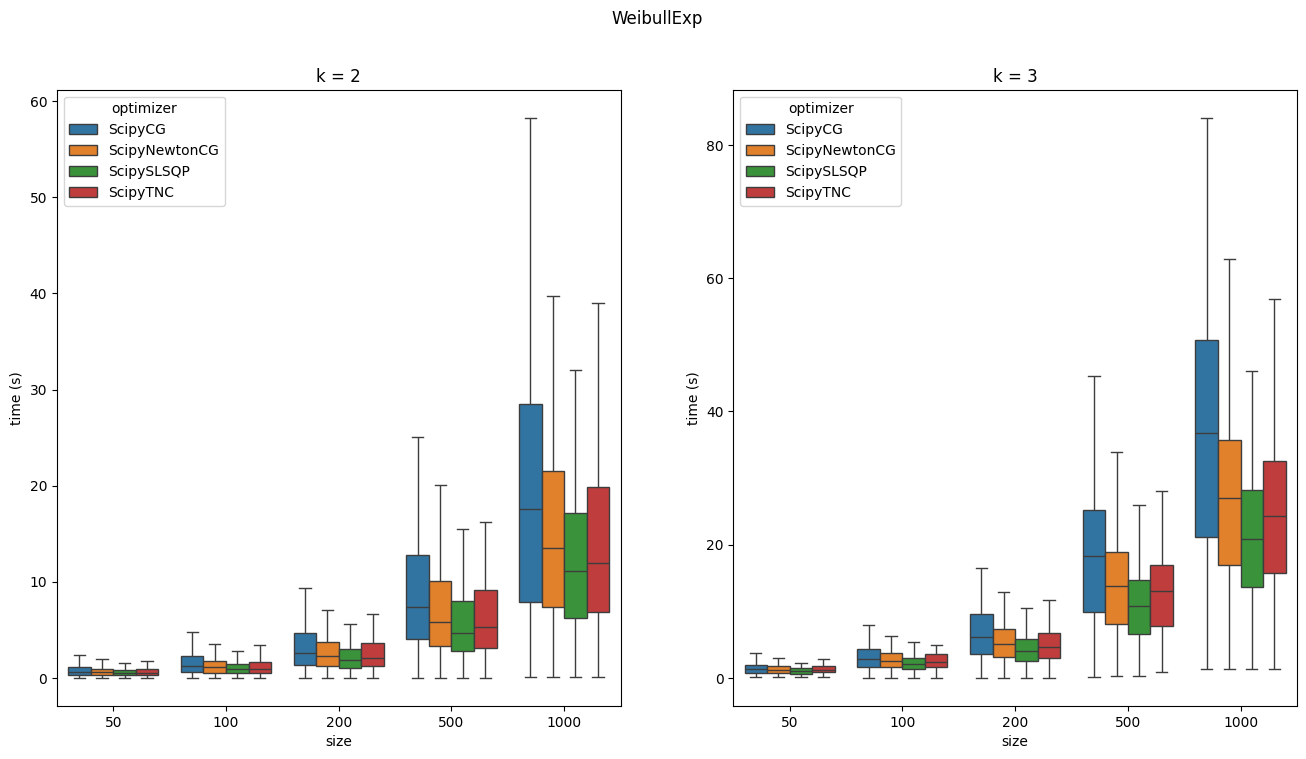

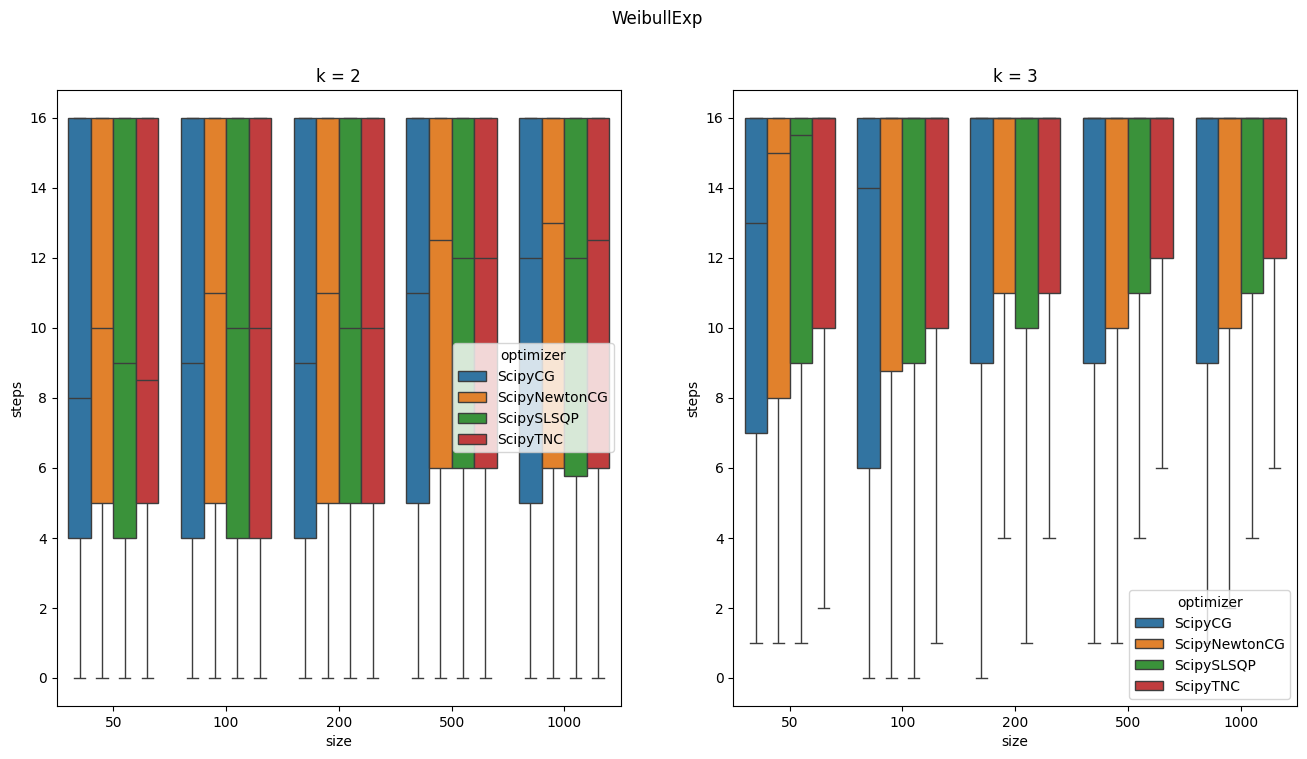

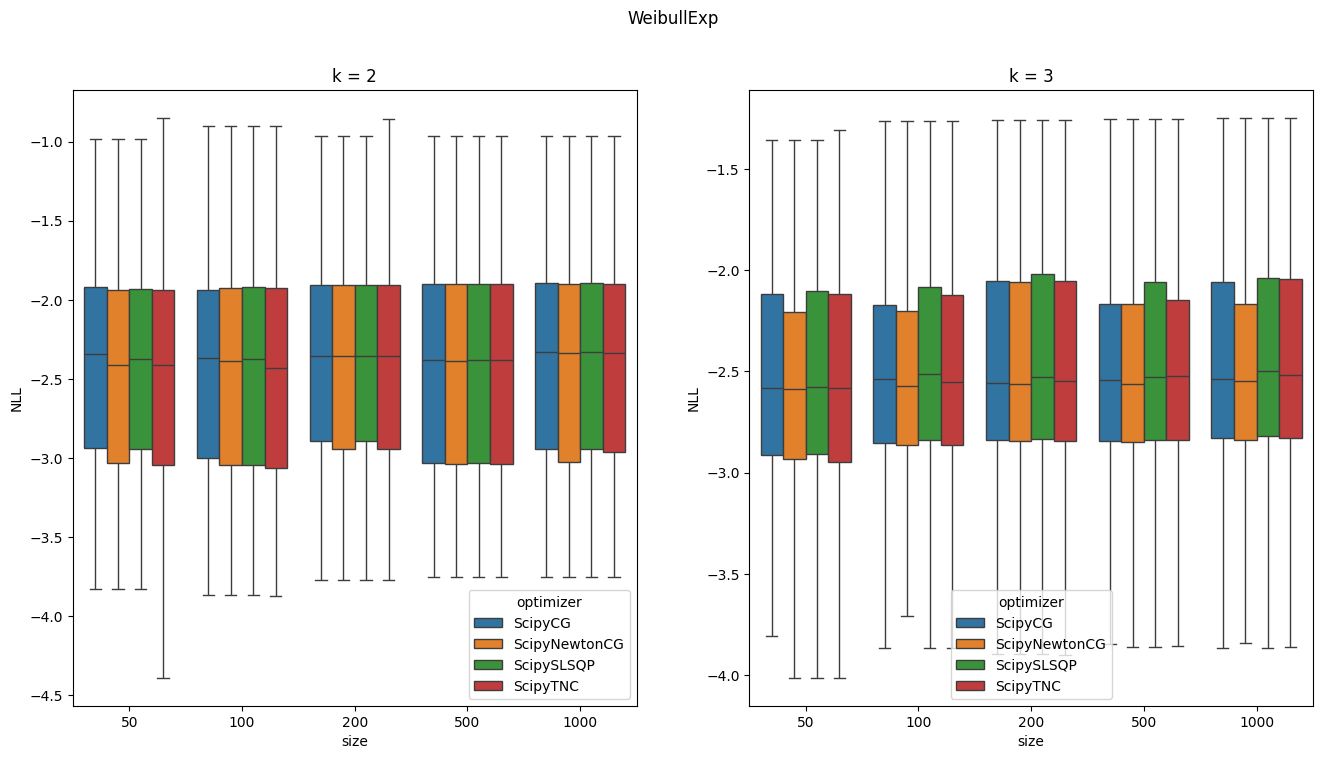

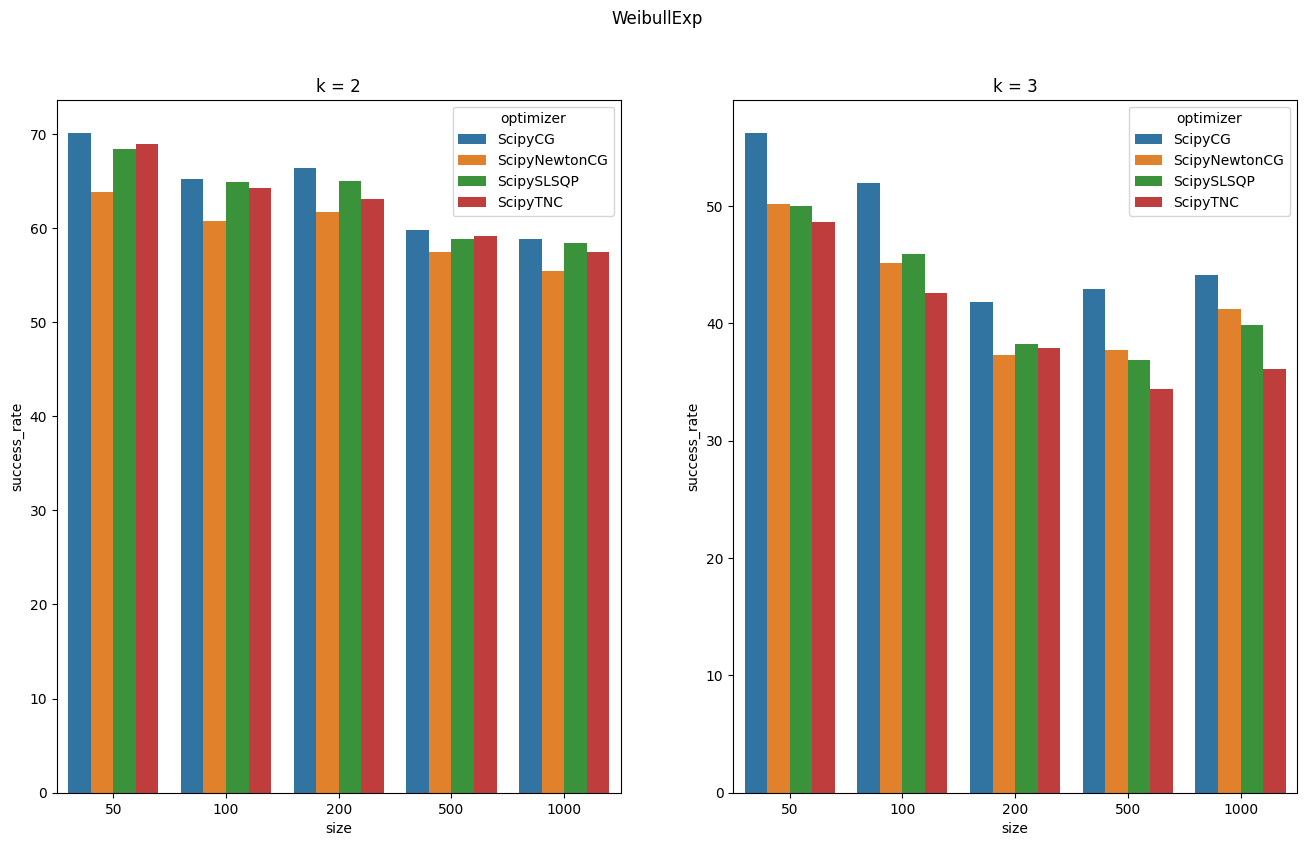

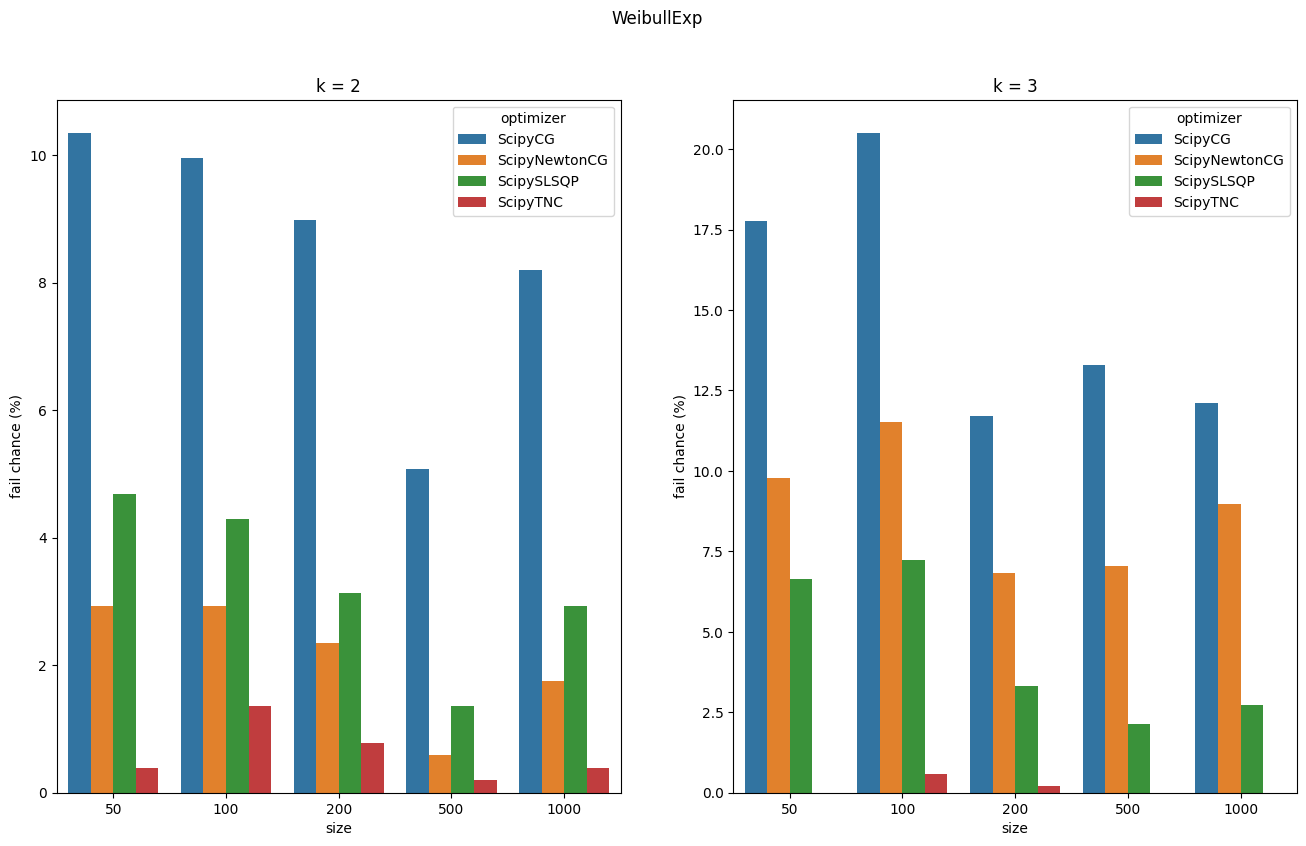

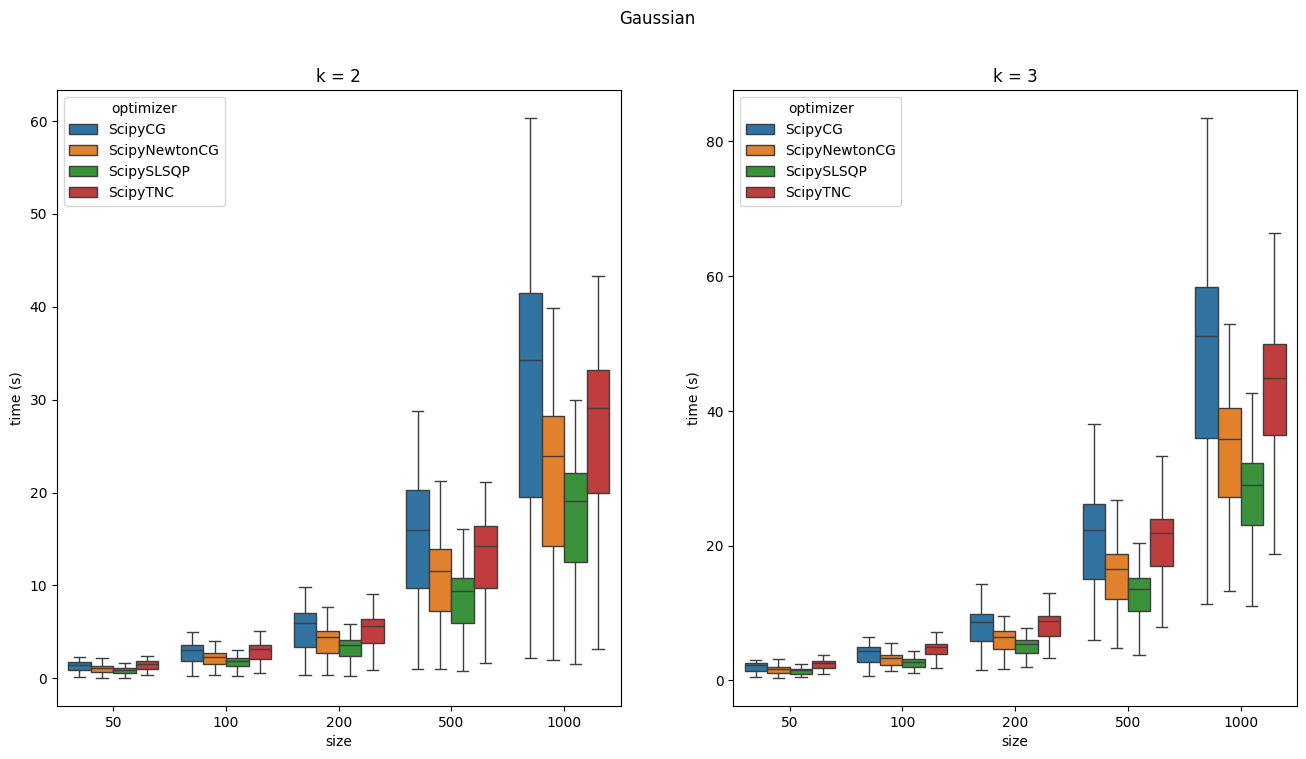

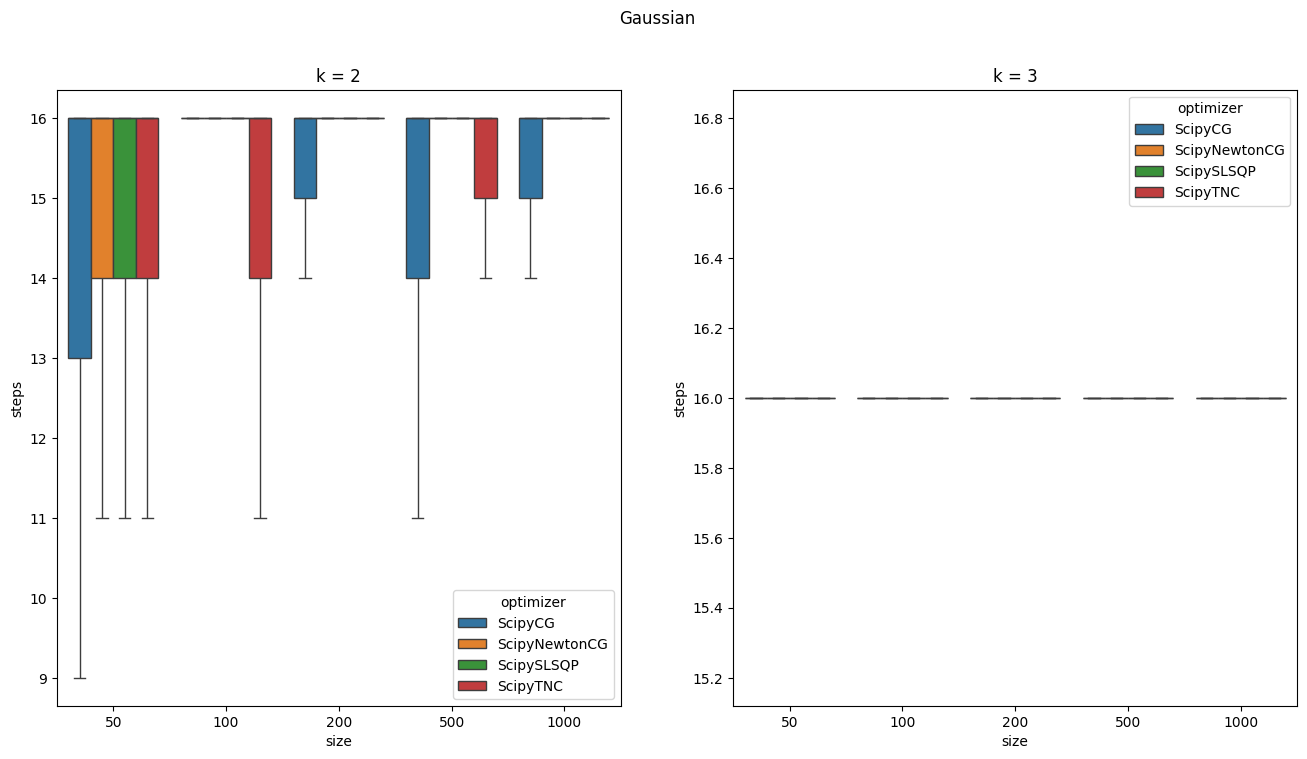

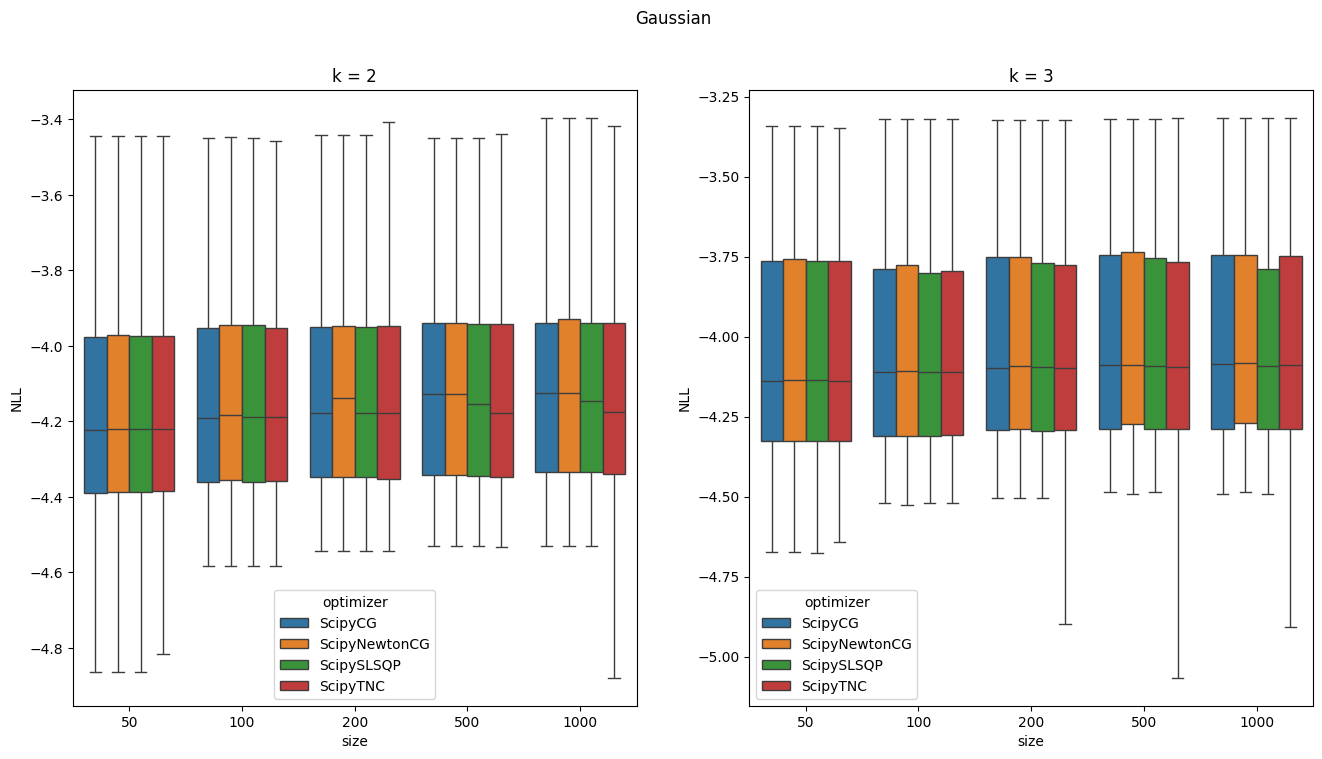

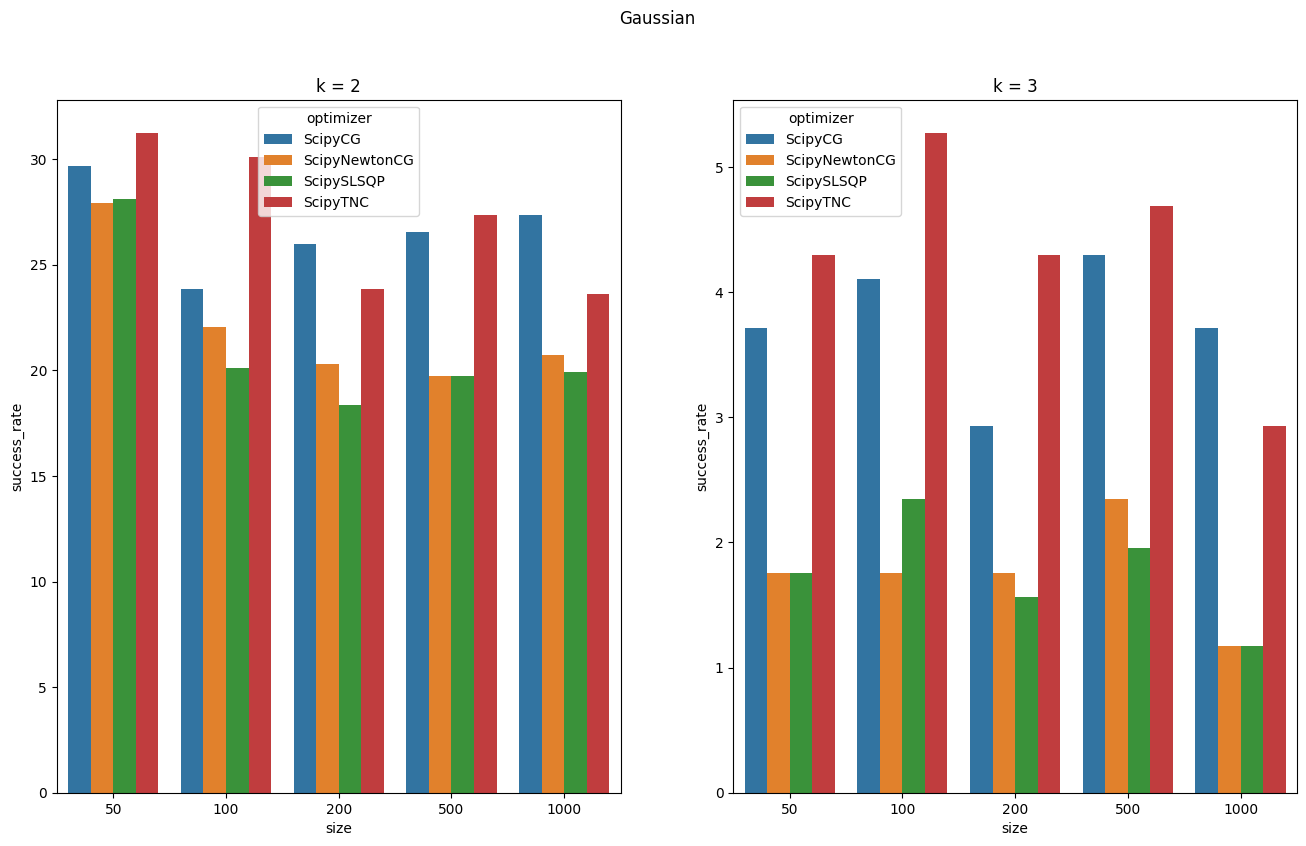

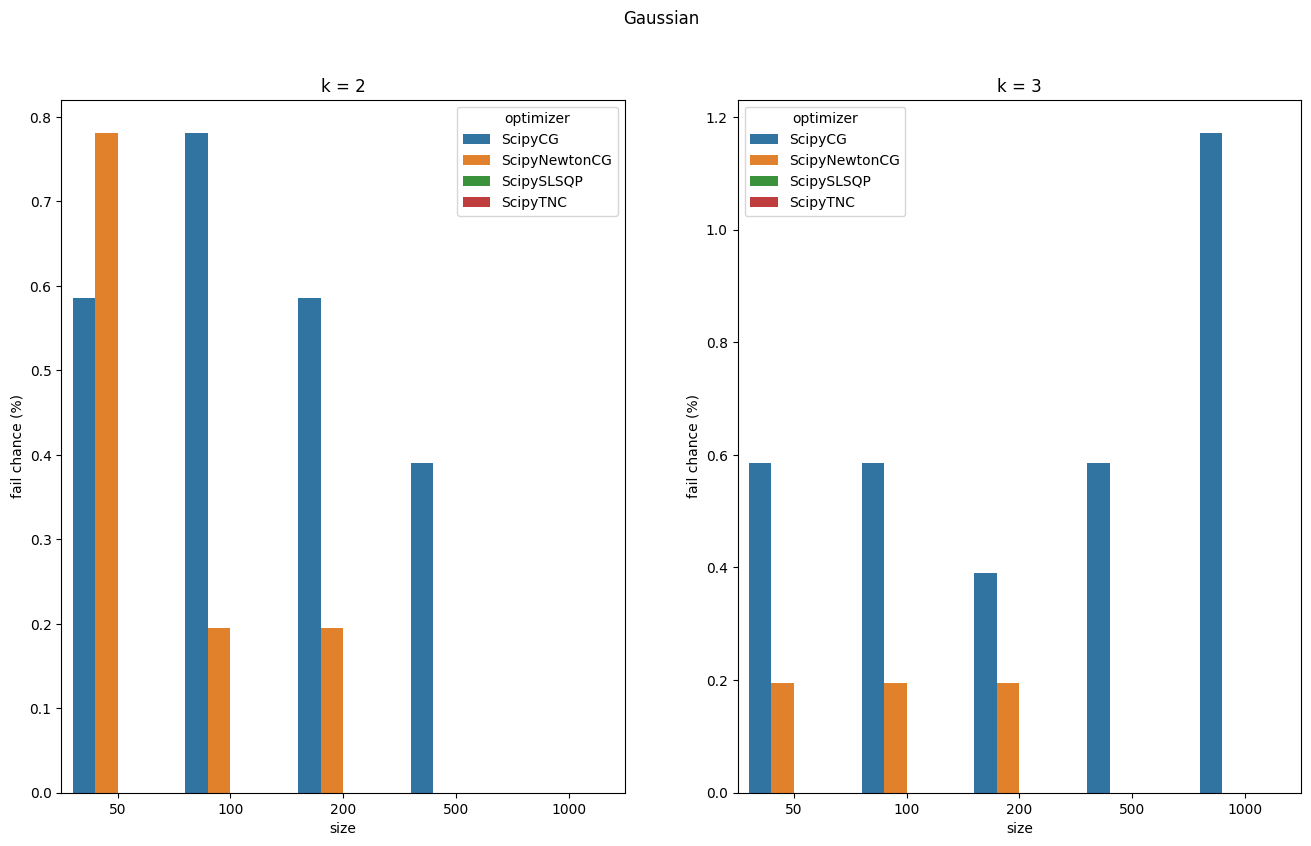

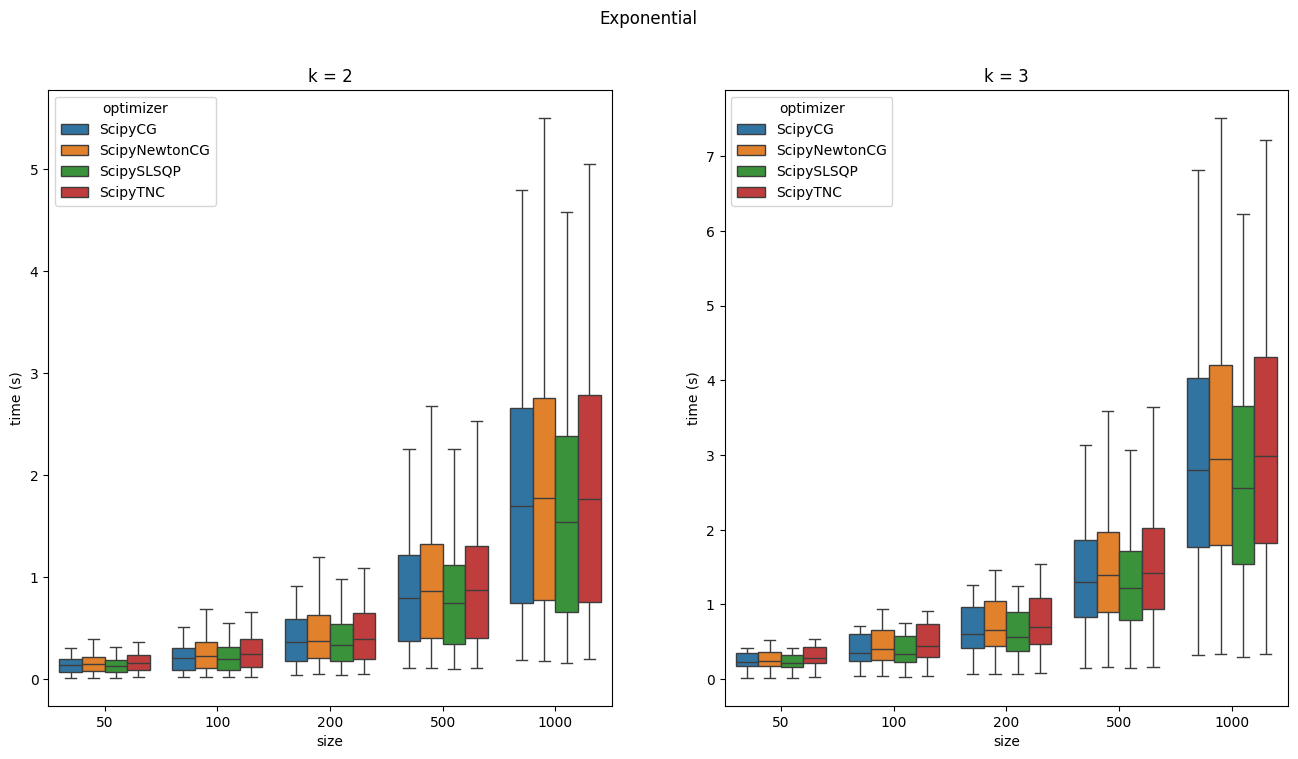

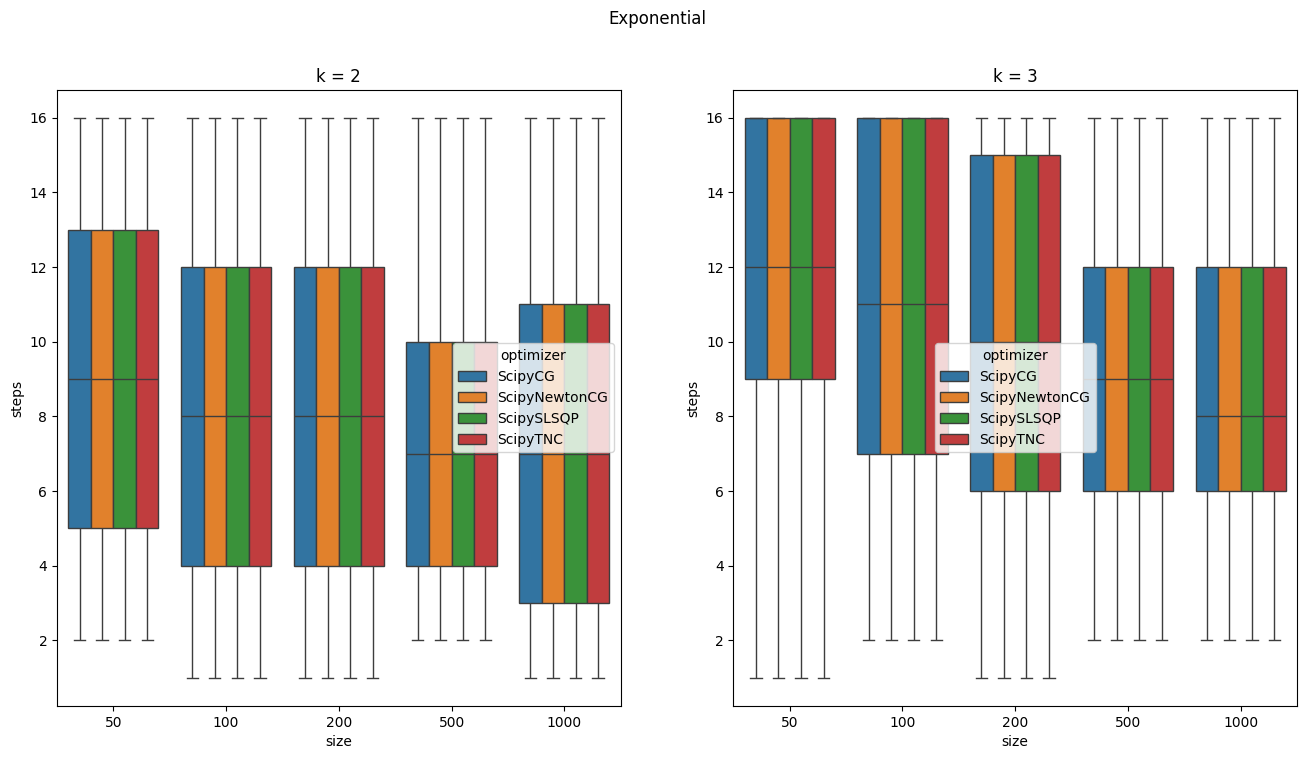

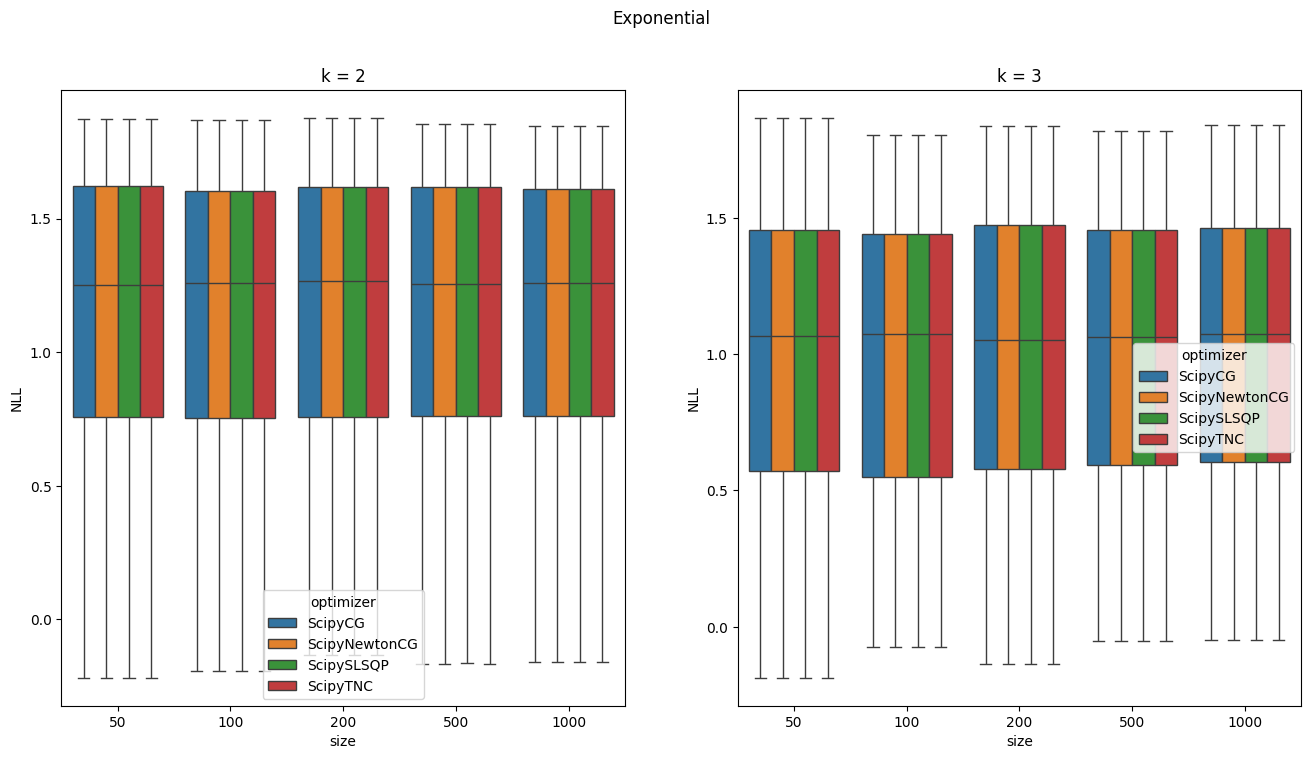

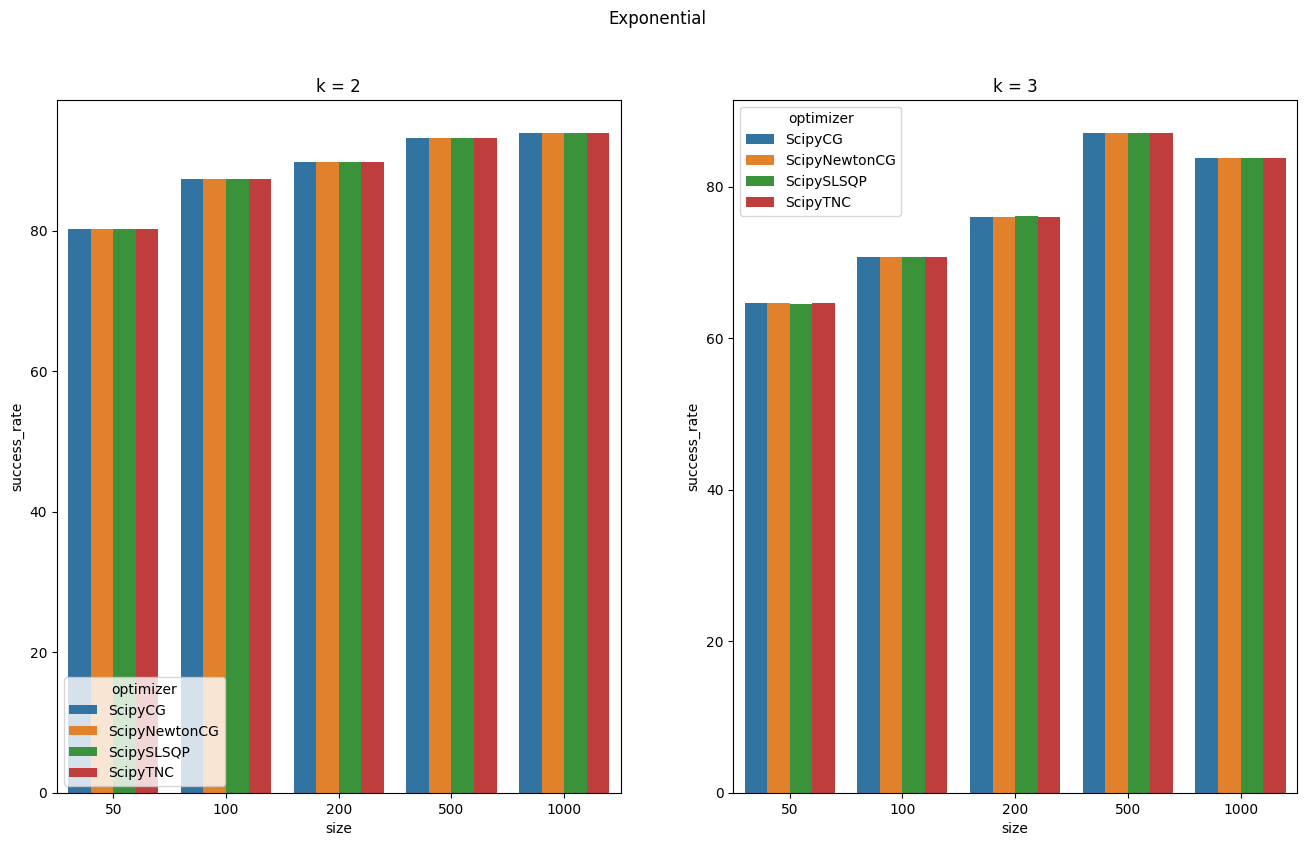

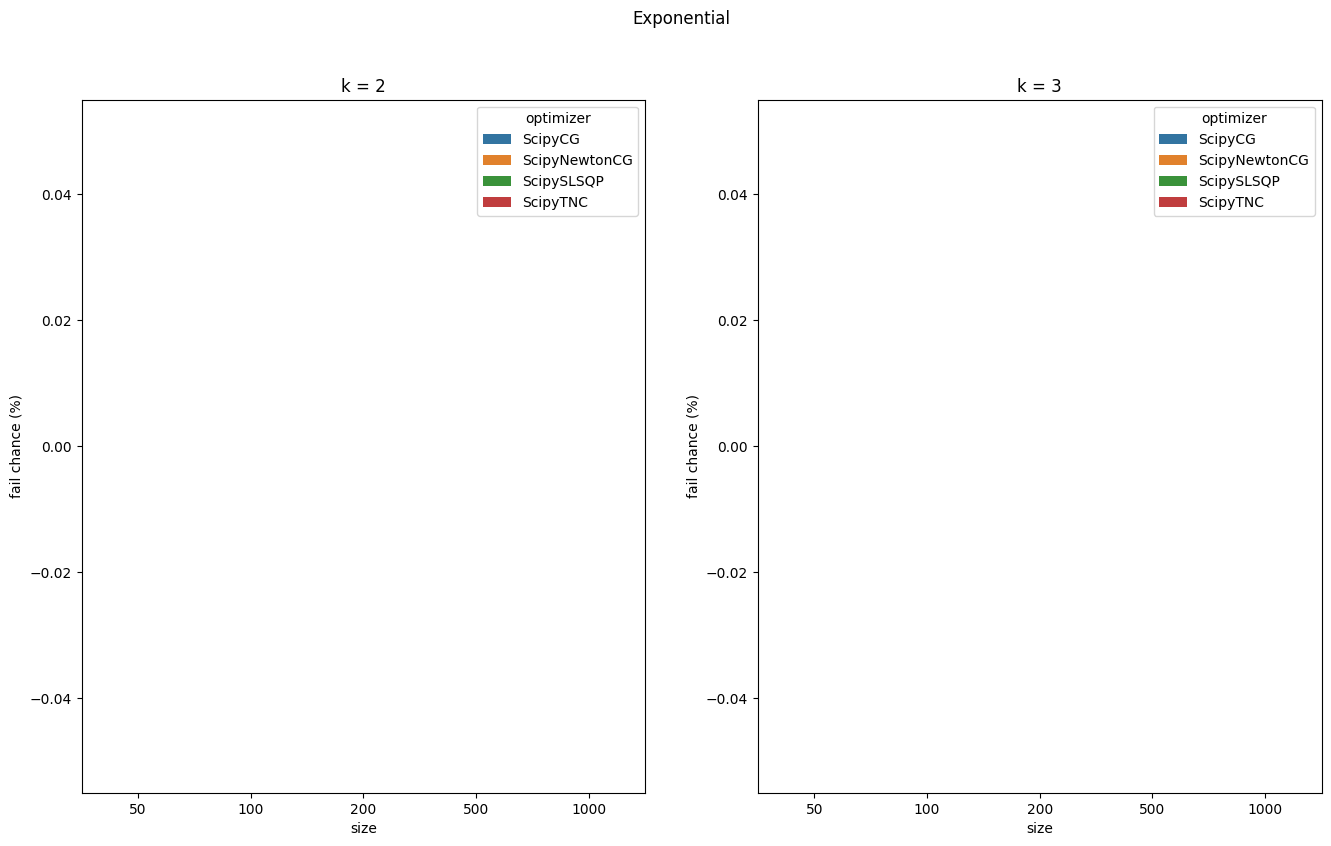

In [20]:
for model in mdf["model"].unique():
    cdf = mdf[mdf["model"] == model]
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(model)
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="time",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="time",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("time (s)")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("time (s)")
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(model)
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="steps",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="steps",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("steps")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("steps")
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(model)
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="occur",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="occur",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("NLL")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("NLL")
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle(model)
    axs[0].set_title("k = 2")
    axs[1].set_title("k = 3")
    sns.barplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="success_rate",
        hue="optimizer",
    )
    sns.barplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="success_rate",
        hue="optimizer",
    )
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle(model)
    sns.barplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="fail_rate",
        hue="optimizer",
    )
    sns.barplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="fail_rate",
        hue="optimizer",
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("fail chance (%)")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("fail chance (%)")
    plt.show()